# Deep Learning Workflow

## Hangar

In [1]:
!pip install grpcio>=1.21.1
!pip install git+https://github.com/tensorwerk/hangar-py
!pip install matplotlib

  Cloning https://github.com/tensorwerk/hangar-py to /tmp/pip-req-build-p3abahcf
  Running command git clone -q https://github.com/tensorwerk/hangar-py /tmp/pip-req-build-p3abahcf
  Stored in directory: /tmp/pip-ephem-wheel-cache-a5lhveud/wheels/41/92/9e/a01c44b33015b54b966237badb395ec6ff104b78676e83c1aa
Successfully built hangar


In [2]:
from hangar import Repository

import numpy as np
import pickle
import gzip
import matplotlib.pyplot as plt

from tqdm import tqdm

In [3]:
!mkdir myhangarrepo
repo = Repository(path='myhangarrepo')
repo.init(user_name='Sherin Thomas', user_email='sherin@gmail.com', remove_old=True)

mkdir: cannot create directory ‘myhangarrepo’: File exists
Hangar Repo initialized at: myhangarrepo/__hangar


'myhangarrepo/__hangar'

In [4]:
repo

            
 Hangar Repository            
     Repository Path  : myhangarrepo/__hangar            
     Writer-Lock Free : True


In [5]:
repo.writer_lock_held
repo.repo_path

'myhangarrepo'

In [6]:
# data link
# https://drive.google.com/drive/folders/1zYdhNN4s5QnqGHRN632hXvfCt4OxsF0l?usp=sharing

In [7]:
datapath = "mnist_data"
import os
os.listdir(datapath)


['data1.npy', 'target1.npy', 'data2.npy', 'target2.npy']

In [8]:
target = np.load(os.path.join(datapath, 'target1.npy'))
data = np.load(os.path.join(datapath, 'data1.npy'))

In [9]:
data.shape, target.shape

((60000, 28, 28), (60000,))

In [10]:
co = repo.checkout(write=True)

In [11]:
data_dset = co.datasets.init_dataset('mnist_data', shape=(28, 28), dtype='uint8')

Dataset Specification:: Name: `mnist_data`, Initialization style: `provided`, Shape: `(28, 28)`, DType: `uint8`, Samples Named: `True`, Variable Shape: `False`, Max Shape: `(28, 28)`
Dataset Initialized: `mnist_data`


In [12]:
co.datasets['mnist_data'] == data_dset

True

In [13]:
target_dset = co.datasets.init_dataset('mnist_target', prototype=target[0])

Dataset Specification:: Name: `mnist_target`, Initialization style: `prototype`, Shape: `()`, DType: `int64`, Samples Named: `True`, Variable Shape: `False`, Max Shape: `()`
Dataset Initialized: `mnist_target`


In [14]:
co.commit('datasets init')
co.close()

Commit operation requested with message: datasets init
(437, 227, 437)
removing all stage hash records
Commit completed. Commit hash: bd266cddc8c97b79243add8f72842d4590a4fe01
writer checkout of master closed


In [15]:
co = repo.checkout(write=True)
data_dset = co.datasets['mnist_data']
target_dset = co.datasets['mnist_target']

In [16]:
with data_dset, target_dset:  # You don't really need this CM if you are not worried about perf
  for i in range(len(data)):
    sample_name = str(i)
    data_dset[sample_name] = data[i]
    target_dset[sample_name] = np.array(target[i])
co.commit('dataset curation: stage 1')
co.close()

Commit operation requested with message: dataset curation: stage 1
(7658229, 1876692, 65536)
removing all stage hash records
Commit completed. Commit hash: caa9df607e25e467814174a76b3d4341c72eebf2
writer checkout of master closed


In [17]:
co = repo.checkout()
dset = co.datasets['mnist_data']

 * Checking out BRANCH: master with current HEAD: caa9df607e25e467814174a76b3d4341c72eebf2


In [18]:
'1' in dset

True

In [19]:
dset.keys()

<generator object DatasetDataReader.keys at 0x7fec755ef930>

In [20]:
next(dset.values()).shape

(28, 28)

In [21]:
dset


 Hangar DatasetDataReader                 
    Dataset Name     : mnist_data                
    Schema UUID      : 6aa5a456944811e9ac622ba9d94fed03                
    Schema Hash      : ed0767935a22                
    Variable Shape   : False                
    (max) Shape      : (28, 28)                
    Datatype         : <class 'numpy.uint8'>                
    Named Samples    : True                
    Access Mode      : r                
    Num Samples      : 60000


0


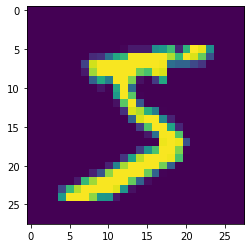

In [22]:
for key, value in dset.items():
    print(key)
    plt.imshow(value)
    break

In [23]:
repo.log()

* caa9df607e25e467814174a76b3d4341c72eebf2 (master) : dataset curation: stage 1
* bd266cddc8c97b79243add8f72842d4590a4fe01 : datasets init


In [24]:
del dset['1']

TypeError: 'DatasetDataReader' object does not support item deletion

### Metadata

In [ ]:
co = repo.checkout(write=True)
co.metadata['DataSource'] = "Sherin"
co.commit("Added source")
co.close()

### Safety from python "oddities" is built in Hangar's very essense.

In [ ]:
co = repo.checkout(write=True)
data_dset = co.datasets['mnist_data']
co.close()
data_dset['1']

### What you put in is what you get out
All data is hashed by cryptographically secure hash algorithms (blake2b with 20byte digest length)
A commit is entirely self sufficient, and it's hash depends on the hash of previous references
For performance reasons, data hash is only calculated / verified when:

a sample is added to a dataset
data is fetched from a remote repo
data is sent to a remote repo
During regular read access, data integrity is ensured via fletcher32 / crc32 checksums

Backend store utilities provide well validated, trusted, and performant implementations

## Branching & Merging
- Time travel through the historical evolution of a dataset
- Zero-cost Branching to enable exploratory analysis and collaboration
- Cheap Merging to build datasets over time (with multiple collaborators)
- Completely abstracted organization and management of data files on disk
- Ability to only retrieve a small portion of the data (as needed) while still maintaining complete historical record
- Ability to push and pull changes directly to collaborators or a central server (ie a truly distributed version control system)

In [ ]:
repo.create_branch('stage2')

In [ ]:
co2 = repo.checkout(branch_name='stage2', write=True)

In [ ]:
target = np.load(os.path.join(datapath, 'target2.npy'))
data = np.load(os.path.join(datapath, 'data2.npy'))
target.shape, data.shape

In [ ]:
with co2.datasets['mnist_data'] as ddset, co2.datasets['mnist_target'] as tdset:
    current_index = len(ddset)
    for i in range(len(data)):
        sample_name = str(current_index + i)
        ddset[sample_name] = data[i]
        tdset[sample_name] = np.array(target[i])
co2.metadata['DataSource'] = "Somebody else"
co2.commit('Data curation: stage2')
co2.close()

In [ ]:
repo.list_branch_names()

In [ ]:
repo.log(branch_name='stage2')

In [ ]:
co = repo.checkout(write=True)

In [ ]:
# Dummy commit to make the diversion
co.metadata['RandomeKey'] = "RandomValue"
co.commit("Dummy metadata")

In [ ]:
co.merge("Merging stage2", dev_branch='stage2')

In [ ]:
co.close()

In [ ]:
repo.log()

In [ ]:
repo._details()

## PyTorch
- Dynamic Graph
- torch.nn
- Datasets & Dataloaders
- Training
    - Autograd
    - Optimization
- Validation
- Serializing

In [25]:
import torch

ModuleNotFoundError: No module named 'torch'